<a href="https://colab.research.google.com/github/enelene/Facial-Expression-Recognition-Challenge/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell to upload your kaggle.json
from google.colab import files
files.upload() # Choose the kaggle.json file you downloaded

# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 89% 255M/285M [00:00<00:00, 833MB/s] 
100% 285M/285M [00:00<00:00, 874MB/s]


In [ ]:
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d fer2013_data

In [ ]:
!git clone https://github.com/enelene/Facial-Expression-Recognition-Challenge.git

Cloning into 'Facial-Expression-Recognition-Challenge'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 29.12 KiB | 29.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!pip install wandb -q

In [ ]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egabe21 (egabe21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt


In [ ]:
!tar -xzvf ../fer2013_data/fer2013.tar.gz -C ../fer2013_data/

tar (child): ../fer2013_data/fer2013.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
cat ../fer2013_data/fer2013/README

If you use this dataset in your research work, please cite

"Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

See fer2013.bib for a bibtex entry.


In [ ]:
import pandas as pd

# Try loading train.csv first
try:
    train_df = pd.read_csv('fer2013_data/train.csv')
    print("train.csv head:")
    print(train_df.head())
    print("\ntrain.csv columns:", train_df.columns)
    print("\ntrain.csv info:")
    train_df.info()
except FileNotFoundError:
    print("train.csv not found directly. Was fer2013.tar.gz extracted if it contained it?")

# Similarly for test.csv
try:
    test_df = pd.read_csv('fer2013_data/test.csv')
    print("\ntest.csv head:")
    print(test_df.head())
except FileNotFoundError:
    print("test.csv not found directly.")


# And icml_face_data.csv
try:
    icml_df = pd.read_csv('fer2013_data/icml_face_data.csv')
    print("\nicml_face_data.csv head:")
    print(icml_df.head())
    print("\nicml_face_data.csv columns:", icml_df.columns)
    print("\nicml_face_data.csv info:")
    icml_df.info()
except FileNotFoundError:
    print("icml_face_data.csv not found directly.")

train.csv head:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

train.csv columns: Index(['emotion', 'pixels'], dtype='object')

train.csv info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB

test.csv head:
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 

In [ ]:
try:
    fer2013_df = pd.read_csv('fer2013_data/fer2013/fer2013.csv')
    print("\nfer2013.csv head:")
    print(fer2013_df.head())
except FileNotFoundError:
    print("test.csv not found directly.")

test.csv not found directly.


In [ ]:
data_path = 'fer2013_data/icml_face_data.csv'
df = pd.read_csv(data_path)

df.columns = df.columns.str.strip()
print("Cleaned column names:", df.columns)

print(df.head())
print("\nDataset shape:", df.shape)
print("\nEmotion distribution:\n", df['emotion'].value_counts())
print("\nUsage distribution:\n", df['Usage'].value_counts())

# Emotion labels (as defined before)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
num_classes = len(emotion_labels)

# --- 2. Split DataFrames based on 'Usage' column ---
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples (PublicTest): {len(val_df)}")
print(f"Test samples (PrivateTest): {len(test_df)}")


Cleaned column names: Index(['emotion', 'Usage', 'pixels'], dtype='object')
   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

Dataset shape: (35887, 3)

Emotion distribution:
 emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Usage distribution:
 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Training samples: 28709
Validation samples (PublicTest): 3589
Test samples (PrivateTest): 3589


In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pixel_strings = self.df['pixels'].values
        self.emotions = self.df['emotion'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Convert pixel string to numpy array and then to PIL Image
        pixel_data = np.fromstring(self.pixel_strings[idx], dtype=int, sep=' ').reshape(48, 48).astype('uint8')
        image = Image.fromarray(pixel_data) # Create PIL image from grayscale numpy array
        emotion = torch.tensor(self.emotions[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, emotion

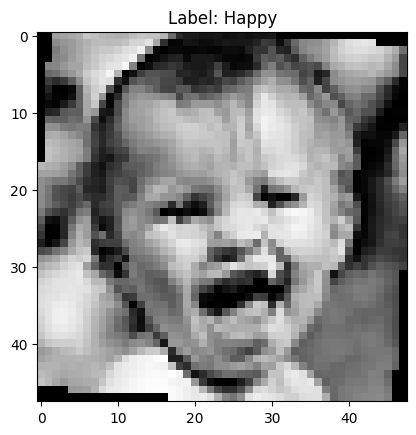

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if 'train_df' in locals():
    train_dataset = FER2013Dataset(train_df, transform=train_transform)
    val_dataset = FER2013Dataset(val_df, transform=val_test_transform) # Use PublicTest for validation
    test_dataset = FER2013Dataset(test_df, transform=val_test_transform)  # Use PrivateTest for final testing

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Visualize a sample
    def imshow(tensor_img, title=None):
        img = tensor_img.clone().squeeze(0)
        img = img * 0.5 + 0.5 # Unnormalize
        plt.imshow(img.numpy(), cmap='gray')
        if title is not None:
            plt.title(title)
        plt.show()

    try:
        images, labels = next(iter(train_loader))
        idx_to_show = 0
        imshow(images[idx_to_show], title=f"Label: {emotion_labels[labels[idx_to_show].item()]}")
    except Exception as e:
        print(f"Could not display image: {e}.")
else:
    print("train_df not defined. Skipping DataLoader and visualization.")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import pandas as pd

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes_param):
        super(SimpleCNN, self).__init__()
        # Input is 1x48x48 (grayscale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # (16, 48, 48)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (16, 24, 24)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # (32, 24, 24)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # (32, 12, 12)

        # Flatten the output for the fully connected layer
        # 32 channels * 12 * 12 image size = 32 * 144 = 4608
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Basic regularization
        self.fc2 = nn.Linear(128, num_classes_param)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
if 'num_classes' not in globals():
    print("Error: num_classes is not defined.")
    exit()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure num_classes is defined before this line
model = SimpleCNN(num_classes_param=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
learning_rate_initial = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate_initial)


Using device: cuda
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
config_wandb = {
    "learning_rate": learning_rate_initial,
    "architecture": "SimpleCNN_Baseline",
    "dataset": "FER2013_from_icml_face_data",
    "epochs": 15, # Start with a moderate number for the baseline
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.5,
    "notes": "Baseline model with 2 conv layers and 1 dropout layer in FC part."
}

run = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb,
    name=f"run-{config_wandb['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}"
)


In [ ]:
def train_model_func(model_to_train, t_loader, v_loader, loss_criterion, opt, num_epochs_total, dev, current_wandb_run, run_name_prefix="train"):

    best_val_accuracy = 0.0
    best_model_path = f"{run_name_prefix}_best_model.pth"

    current_wandb_run.watch(model_to_train, loss_criterion, log="gradients", log_freq=100)

    for epoch in range(num_epochs_total):
        model_to_train.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(t_loader):
            images = images.to(dev)
            labels = labels.to(dev)

            outputs = model_to_train(images)
            loss = loss_criterion(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs_total}], Step [{i+1}/{len(t_loader)}], Batch Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(t_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # Validation phase
        model_to_train.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in v_loader:
                images = images.to(dev)
                labels = labels.to(dev)
                outputs = model_to_train(images)
                loss = loss_criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(v_loader.dataset)
        epoch_val_acc = correct_val / total_val

        print(f'Epoch [{epoch+1}/{num_epochs_total}]:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Log metrics to Wandb
        current_wandb_run.log({
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "train_accuracy": epoch_train_acc,
            "val_loss": epoch_val_loss,
            "val_accuracy": epoch_val_acc,
            "learning_rate_current": opt.param_groups[0]['lr'] # Log current LR
        })

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model_to_train.state_dict(), best_model_path)
            wandb.save(best_model_path) # This saves the file to Wandb's cloud storage for the run
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f} at epoch {epoch+1}")

    print('Finished Training')
    print(f"Best validation accuracy during training: {best_val_accuracy:.4f}")
    #loading the best model state for any final evaluations after the loop
    model_to_train.load_state_dict(torch.load(best_model_path))
    return best_model_path



In [ ]:
if 'train_loader' in globals() and len(train_loader) > 0 and 'val_loader' in globals() and len(val_loader) > 0:
    print(f"Starting training for the baseline model: {config_wandb['architecture']}")
    best_model_file_baseline = train_model_func(model, train_loader, val_loader, criterion, optimizer,
                                      num_epochs_total=config_wandb["epochs"], dev=device,
                                      current_wandb_run=run,
                                      run_name_prefix=config_wandb["architecture"])
    print(f"Best model from baseline training saved to: {best_model_file_baseline}")

    trained_model_artifact = wandb.Artifact(
        name = f"{config_wandb['architecture']}_final_model",
        type="model",
        description=f"Final trained model state for {config_wandb['architecture']}",
        metadata=config_wandb # Add all hyperparameters
    )
    trained_model_artifact.add_file(best_model_file_baseline)
    run.log_artifact(trained_model_artifact)
    print(f"Logged {best_model_file_baseline} as a Wandb artifact.")

else:
    print("DataLoaders (train_loader or val_loader) are not properly initialized or are empty. Skipping training.")

if 'run' in globals() and run is not None:
    run.finish()
    print("Wandb run finished.")

Starting training for the baseline model: SimpleCNN_Baseline
Epoch [1/15], Step [100/449], Batch Loss: 1.7912
Epoch [1/15], Step [200/449], Batch Loss: 1.7170
Epoch [1/15], Step [300/449], Batch Loss: 1.7050
Epoch [1/15], Step [400/449], Batch Loss: 1.6390
Epoch [1/15]:
  Train Loss: 1.6875, Train Acc: 0.3251
  Val Loss: 1.5243, Val Acc: 0.4171
New best model saved with accuracy: 0.4171 at epoch 1
Epoch [2/15], Step [100/449], Batch Loss: 1.5609
Epoch [2/15], Step [200/449], Batch Loss: 1.4988
Epoch [2/15], Step [300/449], Batch Loss: 1.5701
Epoch [2/15], Step [400/449], Batch Loss: 1.6042
Epoch [2/15]:
  Train Loss: 1.5321, Train Acc: 0.4081
  Val Loss: 1.4390, Val Acc: 0.4517
New best model saved with accuracy: 0.4517 at epoch 2
Epoch [3/15], Step [100/449], Batch Loss: 1.7228
Epoch [3/15], Step [200/449], Batch Loss: 1.3938
Epoch [3/15], Step [300/449], Batch Loss: 1.4110
Epoch [3/15], Step [400/449], Batch Loss: 1.5964
Epoch [3/15]:
  Train Loss: 1.4583, Train Acc: 0.4390
  Val Los

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▇▇▇▇▇████
train_loss,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇████
val_loss,█▆▅▄▃▃▂▂▂▁▂▁▁▁▁
epoch,15
learning_rate_current,0.001
train_accuracy,0.5314
train_loss,1.22942
val_accuracy,0.54556


Wandb run finished.


## Experiment 2: DeeperCNN

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes_param):
        super(DeeperCNN, self).__init__() # Call the constructor of the parent nn.Module class

        # Convolutional Block 1
        # Input: (Batch_Size, 1, 48, 48)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Output: (Batch_Size, 32, 48, 48)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: (Batch_Size, 32, 24, 24)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Output: (Batch_Size, 64, 24, 24)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: (Batch_Size, 64, 12, 12)

        # Convolutional Block 3 (NEW)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Output: (Batch_Size, 128, 12, 12)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: (Batch_Size, 128, 6, 6)

        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) # Same dropout rate as baseline for now
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes_param)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Block 3 (NEW)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 128 * 6 * 6)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
deeper_model = DeeperCNN(num_classes_param=num_classes).to(device)
print("--- DeeperCNN Architecture ---")
print(deeper_model)

learning_rate_exp2 = 0.001
optimizer_exp2 = optim.Adam(deeper_model.parameters(), lr=learning_rate_exp2)

config_wandb_exp2 = {
    "learning_rate": learning_rate_exp2,
    "architecture": "DeeperCNN_v1",
    "dataset": "FER2013_from_icml_face_data", # Same dataset
    "epochs": 15,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.5,
    "conv1_filters": 32,
    "conv2_filters": 64,
    "conv3_filters": 128,
    "fc1_units": 256,
    "notes": "Experiment 2: Deeper CNN with 3 conv blocks (32,64,128 filters) and 256 FC units."
}

run_exp2 = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb_exp2,
    name=f"run-{config_wandb_exp2['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
    reinit=True
)
print(f"Wandb run for {config_wandb_exp2['architecture']} initialized: {run_exp2.url}")

if 'train_loader' in globals() and 'val_loader' in globals() and 'criterion' in globals():
    print(f"\nStarting training for: {config_wandb_exp2['architecture']}")

    best_model_file_exp2 = train_model_func(
        model_to_train=deeper_model,
        t_loader=train_loader,
        v_loader=val_loader,
        loss_criterion=criterion,
        opt=optimizer_exp2,
        num_epochs_total=config_wandb_exp2["epochs"],
        dev=device,
        current_wandb_run=run_exp2,
        run_name_prefix=config_wandb_exp2["architecture"]
    )
    print(f"Best model from {config_wandb_exp2['architecture']} training saved to: {best_model_file_exp2}")

    trained_model_artifact_exp2 = wandb.Artifact(
        name=f"{config_wandb_exp2['architecture']}_model", # Unique artifact name
        type="model",
        description=f"Trained model state for {config_wandb_exp2['architecture']}",
        metadata=config_wandb_exp2
    )
    trained_model_artifact_exp2.add_file(best_model_file_exp2)
    run_exp2.log_artifact(trained_model_artifact_exp2)
    print(f"Logged {best_model_file_exp2} as a Wandb artifact for run {run_exp2.name}.")

else:
    print("Error: DataLoaders (train_loader, val_loader) or criterion not found. Please ensure they are defined.")

if 'run_exp2' in globals() and run_exp2 is not None:
    run_exp2.finish()
    print(f"Wandb run {run_exp2.name} finished.")

--- DeeperCNN Architecture ---
DeeperCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Wandb run for DeeperCNN_v1 initialized: https://wandb.ai/egabe21-free-university-of-tbilisi-/facial-expression-recognition-challenge/runs/cht7k3iq

Starting training for: DeeperCNN_v1
Epoch [1/15], Step [100/449], Batch Loss: 1.7830
Epoch [1/15], Step [200/449], Batch Loss: 1.6605
Epoch [1/15], Step [300/449], Batch Loss: 1.6541
Epoch [1/15], Step [400/449], Batch Loss: 1.5594
Epoch [1/15]:
  Train Loss: 1.6832, Train Acc: 0.3227
  Val Loss: 1.5104, Val Acc: 0.4202
New best model saved with accuracy: 0.4202 at epoch 1
Epoch [2/15], Step [100/449], Batch Loss: 1.4990
Epoch [2/15], Step [200/449], Batch Loss: 1.4863
Epoch [2/15], Step [300/449], Batch Loss: 1.1759
Epoch [2/15], Step [400/449], Batch Loss: 1.2924
Epoch [2/15]:
  Train Loss: 1.4594, Train Acc: 0.4391
  Val Loss: 1.3624, Val Acc: 0.4834
New best model saved with accuracy: 0.4834 at epoch 2
Epoch [3/15], Step [100/449], Batch Loss: 1.4039
Epoch [3/15], Step [200/449], Batch Loss: 1.3212
Epoch [3/15], Step [300/449], Batch Lo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▆▇▇▇▇█████
train_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇▇██████
val_loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
learning_rate_current,0.001
train_accuracy,0.61256
train_loss,1.03501
val_accuracy,0.58373


Wandb run run-DeeperCNN_v1-20250605-141737 finished.


In [ ]:
import torch
import torch.nn as nn

class OverfitCNN(nn.Module):
    def __init__(self, num_classes_param):
        super(OverfitCNN, self).__init__()

        # Block 1 - Wider
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # 64 filters
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) # Output: (64, 24, 24)

        # Block 2 - Wider
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128 filters
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) # Output: (128, 12, 12)

        # Block 3 - Wider
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 256 filters
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2) # Output: (256, 6, 6)

        # Block 4 - New Deep Block
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 512 filters
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (512, 3, 3)

        # Fully Connected Layers
        # Flattened size: 512 * 3 * 3 = 512 * 9 = 4608
        self.fc1 = nn.Linear(512 * 3 * 3, 1024) # Large FC layer
        self.relu5 = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, num_classes_param)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))

        x = x.view(-1, 512 * 3 * 3)

        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
overfitting_model = OverfitCNN(num_classes_param=num_classes).to(device)
print("--- OverfitCNN Architecture (Experiment 3A) ---")
print(overfitting_model)

learning_rate_exp3a = 0.001
optimizer_exp3a = optim.Adam(overfitting_model.parameters(), lr=learning_rate_exp3a)

config_wandb_exp3a = {
    "learning_rate": learning_rate_exp3a,
    "architecture": "OverfitCNN_v1_NoDropout",
    "dataset": "FER2013_from_icml_face_data",
    "epochs": 25, # Increase epochs to give more time to overfit
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.0,
    "conv1_filters": 64,
    "conv2_filters": 128,
    "conv3_filters": 256,
    "conv4_filters": 512,
    "fc1_units": 1024,
    "notes": "Experiment 3A: Very deep/wide CNN with NO FC dropout, aiming to observe overfitting."
}

run_exp3a = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb_exp3a,
    name=f"run-{config_wandb_exp3a['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
    reinit=True
)
print(f"Wandb run for {config_wandb_exp3a['architecture']} initialized: {run_exp3a.url}")


if 'train_loader' in globals() and 'val_loader' in globals() and 'criterion' in globals():
    print(f"\nStarting training for: {config_wandb_exp3a['architecture']}")

    best_model_file_exp3a = train_model_func(
        model_to_train=overfitting_model,
        t_loader=train_loader,
        v_loader=val_loader,
        loss_criterion=criterion,
        opt=optimizer_exp3a,
        num_epochs_total=config_wandb_exp3a["epochs"],
        dev=device,
        current_wandb_run=run_exp3a,
        run_name_prefix=config_wandb_exp3a["architecture"]
    )
    print(f"Best model from {config_wandb_exp3a['architecture']} training saved to: {best_model_file_exp3a}")

    trained_model_artifact_exp3a = wandb.Artifact(
        name=f"{config_wandb_exp3a['architecture']}_model",
        type="model",
        description=f"Trained model state for {config_wandb_exp3a['architecture']}",
        metadata=config_wandb_exp3a
    )
    trained_model_artifact_exp3a.add_file(best_model_file_exp3a)
    run_exp3a.log_artifact(trained_model_artifact_exp3a)
    print(f"Logged {best_model_file_exp3a} as a Wandb artifact for run {run_exp3a.name}.")
else:
    print("Error: DataLoaders (train_loader, val_loader) or criterion not found.")

if 'run_exp3a' in globals() and run_exp3a is not None:
    run_exp3a.finish()
    print(f"Wandb run {run_exp3a.name} finished.")

--- OverfitCNN Architecture (Experiment 3A) ---
OverfitCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


Wandb run for OverfitCNN_v1_NoDropout initialized: https://wandb.ai/egabe21-free-university-of-tbilisi-/facial-expression-recognition-challenge/runs/tbq6yyct

Starting training for: OverfitCNN_v1_NoDropout
Epoch [1/25], Step [100/449], Batch Loss: 1.8187
Epoch [1/25], Step [200/449], Batch Loss: 1.5899
Epoch [1/25], Step [300/449], Batch Loss: 1.5914
Epoch [1/25], Step [400/449], Batch Loss: 1.6447
Epoch [1/25]:
  Train Loss: 1.6509, Train Acc: 0.3369
  Val Loss: 1.4526, Val Acc: 0.4341
New best model saved with accuracy: 0.4341 at epoch 1
Epoch [2/25], Step [100/449], Batch Loss: 1.6167
Epoch [2/25], Step [200/449], Batch Loss: 1.4581
Epoch [2/25], Step [300/449], Batch Loss: 1.2598
Epoch [2/25], Step [400/449], Batch Loss: 1.0987
Epoch [2/25]:
  Train Loss: 1.3685, Train Acc: 0.4740
  Val Loss: 1.2874, Val Acc: 0.5007
New best model saved with accuracy: 0.5007 at epoch 2
Epoch [3/25], Step [100/449], Batch Loss: 1.2936
Epoch [3/25], Step [200/449], Batch Loss: 1.2863
Epoch [3/25], St

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇█████████████
val_loss,█▅▃▂▂▁▁▂▂▁▁▁▁▂▂▃▂▃▃▄▅▇▇▇▇
epoch,25
learning_rate_current,0.001
train_accuracy,0.80052
train_loss,0.54465
val_accuracy,0.59432


Wandb run run-OverfitCNN_v1_NoDropout-20250605-143435 finished.


In [ ]:
class RegularizedOverfitCNN(nn.Module):
    def __init__(self, num_classes_param):
        super(RegularizedOverfitCNN, self).__init__()
        # --- Block 1 ---
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64) # ADDED BN
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        # self.drop2d1 = nn.Dropout2d(p=0.25) # Optional: Spatial Dropout

        # --- Block 2 ---
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128) # ADDED BN
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # --- Block 3 ---
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256) # ADDED BN
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        # self.drop2d2 = nn.Dropout2d(p=0.25) # Optional

        # --- Block 4 ---
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512) # ADDED BN
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024) # ADDED BN for FC
        self.relu5 = nn.ReLU()
        self.dropout_fc = nn.Dropout(p=0.5) # ADDED/INCREASED FC Dropout

        self.fc2 = nn.Linear(1024, num_classes_param)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        # x = self.drop2d1(x)
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        # x = self.drop2d2(x)
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 3 * 3)
        x = self.dropout_fc(self.relu5(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        return x

In [ ]:
model_exp3b = RegularizedOverfitCNN(num_classes_param=num_classes).to(device)
print(model_exp3b)

learning_rate_exp3b = 0.001
optimizer_reg_overfit = optim.Adam(model_exp3b.parameters(), lr=learning_rate_exp3b)

config_wandb_exp3b = {
    "learning_rate": learning_rate_exp3b,
    "architecture": "RegularizedOverfitCNN_v1",
    "dataset": "FER2013_from_icml_face_data",
    "epochs": 25, # Same as OverfitCNN for comparison
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.5, # Added/Increased dropout
    "batch_norm_conv": True, # Indicated Batch Norm is used
    "batch_norm_fc": True,
    "weight_decay": 1e-4, # If you added it
    # ... (other params like filter counts if they are the same as OverfitCNN)
    "notes": "Experiment 3B: Regularized version of OverfitCNN with BN, Dropout 0.5, and L2."
}

# For Experiment 3B
run_exp3b = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb_exp3b,
    name=f"run-{config_wandb_exp3b['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
    reinit=True
)

# 5. Train the new model (reusing train_model_func)
if 'train_loader' in globals() and 'val_loader' in globals() and 'criterion' in globals():
    print(f"\nStarting training for: {config_wandb_exp3b['architecture']}")

    best_model_file_exp3b = train_model_func(
        model_to_train=model_exp3b, # Pass the correct model
        t_loader=train_loader,
        v_loader=val_loader,
        loss_criterion=criterion,
        opt=optimizer_reg_overfit, # Pass the correct optimizer
        num_epochs_total=config_wandb_exp3b["epochs"],
        dev=device,
        current_wandb_run=run_exp3b, # Pass the correct Wandb run object
        run_name_prefix=config_wandb_exp3b["architecture"]
    )
    print(f"Best model from {config_wandb_exp3b['architecture']} training saved to: {best_model_file_exp3b}")

    # Log the trained model as an artifact
    trained_model_artifact_exp3b = wandb.Artifact(
        name=f"{config_wandb_exp3b['architecture']}_model",
        type="model",
        description=f"Trained model state for {config_wandb_exp3a['architecture']}",
        metadata=config_wandb_exp3b
    )
    trained_model_artifact_exp3b.add_file(best_model_file_exp3b)
    run_exp3b.log_artifact(trained_model_artifact_exp3b)
    print(f"Logged {best_model_file_exp3a} as a Wandb artifact for run {run_exp3b.name}.")
else:
    print("Error: DataLoaders (train_loader, val_loader) or criterion not found.")

# 6. Finish the Wandb run for Experiment 3A
if 'run_exp3b' in globals() and run_exp3a is not None:
    run_exp3b.finish()
    print(f"Wandb run {run_exp3b.name} finished.")

RegularizedOverfitCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=


Starting training for: RegularizedOverfitCNN_v1
Epoch [1/25], Step [100/449], Batch Loss: 1.5278
Epoch [1/25], Step [200/449], Batch Loss: 1.4911
Epoch [1/25], Step [300/449], Batch Loss: 1.4309
Epoch [1/25], Step [400/449], Batch Loss: 1.5793
Epoch [1/25]:
  Train Loss: 1.5148, Train Acc: 0.4197
  Val Loss: 1.3042, Val Acc: 0.5085
New best model saved with accuracy: 0.5085 at epoch 1
Epoch [2/25], Step [100/449], Batch Loss: 1.3449
Epoch [2/25], Step [200/449], Batch Loss: 1.1668
Epoch [2/25], Step [300/449], Batch Loss: 1.3037
Epoch [2/25], Step [400/449], Batch Loss: 1.3896
Epoch [2/25]:
  Train Loss: 1.2497, Train Acc: 0.5246
  Val Loss: 1.2413, Val Acc: 0.5308
New best model saved with accuracy: 0.5308 at epoch 2
Epoch [3/25], Step [100/449], Batch Loss: 1.3317
Epoch [3/25], Step [200/449], Batch Loss: 1.4426
Epoch [3/25], Step [300/449], Batch Loss: 1.0556
Epoch [3/25], Step [400/449], Batch Loss: 0.9671
Epoch [3/25]:
  Train Loss: 1.1626, Train Acc: 0.5599
  Val Loss: 1.1618, V

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇█▇▇▇█▇█▇█
val_loss,▇▅▄▄▂▂▁▂▂▁▁▂▂▁▃▃▃▄▅▅▆▇█▇█
epoch,25
learning_rate_current,0.001
train_accuracy,0.86527
train_loss,0.37008
val_accuracy,0.65143


Wandb run run-RegularizedOverfitCNN_v1-20250605-145737 finished.


In [ ]:
print("--- Setting up Experiment 4: DeeperCNN_v1 for More Epochs ---")

model_exp4 = DeeperCNN(num_classes_param=num_classes).to(device)
print("--- DeeperCNN Architecture (Experiment 4) ---")
print(model_exp4)

# Using similar settings as before for fair comparison of epoch effect
learning_rate_exp4 = 0.001
optimizer_exp4 = optim.Adam(model_exp4.parameters(), lr=learning_rate_exp4)

config_wandb_exp4 = {
    "learning_rate": learning_rate_exp4,
    "architecture": "DeeperCNN_v1_MoreEpochs",
    "dataset": "FER2013_from_icml_face_data",
    "epochs": 30,
    "batch_size": batch_size, # Global batch_size
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.5,
    "conv1_filters": 32,
    "conv2_filters": 64,
    "conv3_filters": 128,
    "fc1_units": 256,
    "notes": "Experiment 4: Training DeeperCNN_v1 for 30 epochs to check for further improvement or overfitting."
}

run_exp4 = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb_exp4,
    name=f"run-{config_wandb_exp4['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
    reinit=True
)
print(f"Wandb run for {config_wandb_exp4['architecture']} initialized: {run_exp4.url if run_exp4 else 'Failed to init'}")

if 'train_loader' in globals() and 'val_loader' in globals() and 'criterion' in globals() and run_exp4:
    print(f"\nStarting training for: {config_wandb_exp4['architecture']}")

    best_model_file_exp4 = train_model_func(
        model_to_train=model_exp4,
        t_loader=train_loader,
        v_loader=val_loader,
        loss_criterion=criterion,
        opt=optimizer_exp4,
        num_epochs_total=config_wandb_exp4["epochs"],
        dev=device,
        current_wandb_run=run_exp4,
        run_name_prefix=config_wandb_exp4["architecture"]
    )
    print(f"Best model from {config_wandb_exp4['architecture']} training saved to: {best_model_file_exp4}")

    if best_model_file_exp4 and os.path.exists(best_model_file_exp4):
        trained_model_artifact_exp4 = wandb.Artifact(
            name=f"{config_wandb_exp4['architecture']}_model",
            type="model",
            description=f"Trained model state for {config_wandb_exp4['architecture']}",
            metadata=config_wandb_exp4
        )
        trained_model_artifact_exp4.add_file(best_model_file_exp4)
        run_exp4.log_artifact(trained_model_artifact_exp4)
        print(f"Logged {best_model_file_exp4} as a Wandb artifact for run {run_exp4.name}.")
    else:
        print(f"Model file {best_model_file_exp4} not found for artifact logging.")
else:
    print("Error: DataLoaders, criterion, or Wandb run not properly initialized for Experiment 4.")

if 'run_exp4' in globals() and run_exp4 is not None:
    run_exp4.finish()
    print(f"Wandb run {run_exp4.name} finished.")

--- Setting up Experiment 4: DeeperCNN_v1 for More Epochs ---
--- DeeperCNN Architecture (Experiment 4) ---
DeeperCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


Wandb run for DeeperCNN_v1_MoreEpochs initialized: https://wandb.ai/egabe21-free-university-of-tbilisi-/facial-expression-recognition-challenge/runs/9yqwhg11

Starting training for: DeeperCNN_v1_MoreEpochs
Epoch [1/30], Step [100/449], Batch Loss: 1.7497
Epoch [1/30], Step [200/449], Batch Loss: 1.7105
Epoch [1/30], Step [300/449], Batch Loss: 1.7407
Epoch [1/30], Step [400/449], Batch Loss: 1.6035
Epoch [1/30]:
  Train Loss: 1.7152, Train Acc: 0.3085
  Val Loss: 1.5598, Val Acc: 0.4082
New best model saved with accuracy: 0.4082 at epoch 1
Epoch [2/30], Step [100/449], Batch Loss: 1.4795
Epoch [2/30], Step [200/449], Batch Loss: 1.5225
Epoch [2/30], Step [300/449], Batch Loss: 1.3752
Epoch [2/30], Step [400/449], Batch Loss: 1.3754
Epoch [2/30]:
  Train Loss: 1.5242, Train Acc: 0.4096
  Val Loss: 1.4109, Val Acc: 0.4522
New best model saved with accuracy: 0.4522 at epoch 2
Epoch [3/30], Step [100/449], Batch Loss: 1.3455
Epoch [3/30], Step [200/449], Batch Loss: 1.2322
Epoch [3/30], St

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▅▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,30
learning_rate_current,0.001
train_accuracy,0.62486
train_loss,0.99202
val_accuracy,0.60295


Wandb run run-DeeperCNN_v1_MoreEpochs-20250605-150511 finished.
